In [190]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *

In [199]:
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('../resources/data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])

N=m.df.shape[0]
D_X=2
D_H=5
X = jnp.array(m.df.iloc[:,[1,2]])
Y = jnp.array(m.df.iloc[:,0])
D_Y=1

# the non-linearity we use in our neural network
# Each hidden layer applies a non-linear activation function (nonlin)
# Enables the network to learn complex, non-linear relationships
# z1 and z2 represent transformed feature representations
def nonlin(x):
    return jnp.tanh(x)

# sample first layer (we put unit normal priors on all weights)
# First hidden layer: Transforms input to N × D_H (hidden units)
w1 =m.dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)), sample=True) 
z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations

# sample second layer
# Second hidden layer: Further transforms to N × D_H
w2 =m.dist.normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H)), sample=True) 
z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations

# sample final layer of weights and neural network output
# Final layer (z3) computes linear combination of second hidden layer
w3 = m.dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)), sample=True) 
z3 = jnp.matmul(z2, w3)  # <= output of the neural network

# we put a prior on the observation noise
prec_obs = m.dist.gamma(3.0, 1.0,sample=True)
sigma_obs = 1.0 / jnp.sqrt(prec_obs)

m.dist.normal(z3, sigma_obs,sample=True)

jax.local_device_count 32


Array([[0.82030731],
       [0.84302794],
       [0.80043832],
       [1.07064184],
       [0.96699216],
       [0.75788976],
       [0.88282507],
       [0.99040376],
       [1.74830516],
       [0.39438226],
       [0.67586757],
       [1.36816821],
       [1.17227032],
       [0.91379703],
       [0.35298145],
       [1.19317902],
       [0.91597694],
       [0.81362404],
       [1.10558319],
       [1.09853142],
       [1.05887963],
       [0.97587973],
       [0.67976001],
       [0.71290765],
       [1.35024763],
       [1.90735638],
       [0.59643113],
       [1.85211423],
       [1.4973018 ],
       [1.10253452],
       [1.10461774],
       [0.8538141 ],
       [0.92419356],
       [1.42086943],
       [0.69845039],
       [1.4175316 ],
       [1.18947474],
       [0.98433929],
       [1.21054141],
       [0.8464736 ],
       [1.12437884],
       [1.10059556],
       [0.71843966],
       [0.67805735],
       [1.14318247],
       [1.09619489],
       [1.21954547],
       [1.326

In [202]:
# setup platform------------------------------------------------
m = bi(platform='cpu')
m.data_on_model = dict(X=X, Y=Y)

# define model ------------------------------------------------
def model(X, Y):    
    # sample first layer (we put unit normal priors on all weights)
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H))
    z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations

    # sample second layer
    # Second hidden layer: Further transforms to N × D_H
    w2 = dist.normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H)),  name='w2',shape=(D_H,D_H))
    z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations


    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w3 = dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w3',shape=(D_H,D_Y))

    z3 = jnp.matmul(z2, w3)  # <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = dist.gamma(3.0, 1.0,sample=True,shape=(N,D_Y),name='prec_obs')
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    with numpyro.plate("data", N):
        lk("y", Normal(z3, sigma_obs), obs=Y)


# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 
m.sampler.print_summary(0.89)

/home/sosa/work/BI/bi/main.py:126: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [03:28<00:00,  4.81it/s, 1023 steps of size 8.46e-04. acc. prob=0.93]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
   w1[0,0]      0.12      1.02     -0.05     -1.54      1.60     20.02      1.00
   w1[0,1]     -0.01      1.00     -0.15     -1.71      1.61     16.99      1.02
   w1[0,2]     -0.15      1.00     -0.08     -1.71      1.49      9.63      1.25
   w1[0,3]      0.15      0.89      0.14     -1.23      1.52     41.76      1.04
   w1[0,4]      0.06      1.04     -0.01     -1.47      1.94     22.96      1.06
   w1[1,0]      0.76      0.38      0.72      0.18      1.35     30.58      1.13
   w1[1,1]     -1.01      0.54     -0.96     -1.80     -0.19     16.27      1.00
   w1[1,2]      0.92      0.64      0.77      0.07      1.72     32.81      1.00
   w1[1,3]     -0.61      0.45     -0.47     -1.19     -0.09     24.09      1.03
   w1[1,4]      0.90      0.47      0.84      0.13      1.56     30.47      1.08
   w2[0,0]     -0.88      0.75     -0.91     -2.02      0.12     31.97      1.05
   w2[0,1]      0.92      0

In [203]:
m.sample()

{'w1': Array([[ 5.19983013e-01, -2.73470889e-01,  3.11574657e-01,
          7.30220583e-01,  2.00178212e+00],
        [ 4.92771114e-01,  4.52303726e-01,  8.84373278e-01,
          6.88032453e-04, -7.32530520e-01]], dtype=float64),
 'w2': Array([[ 0.38546063,  0.67268593,  0.04834167,  1.54722022,  0.332303  ],
        [ 0.21560405,  0.57333424,  0.89275439,  0.88310392,  1.28605437],
        [ 1.39644083, -0.70782275,  1.3953333 , -1.93805326, -0.92402373],
        [-0.46018788,  0.30569463,  0.81789006,  0.01793597, -0.06128742],
        [-0.91841769, -0.1329486 , -0.49507136, -0.42838023,  0.93477171]],      dtype=float64),
 'w3': Array([[ 0.13582026],
        [ 0.09055779],
        [-0.40052769],
        [ 0.09743913],
        [-0.14248819]], dtype=float64),
 'y': Array([[-0.39595816, -1.33578968, -0.71235095, ..., -0.18580384,
          0.57364671,  1.05386083],
        [-1.31808032, -0.69387047, -0.63227198, ...,  0.23015732,
          0.2895777 , -0.56492308],
        [-0.0495516

In [104]:
def model(X, Y, D_H, D_Y=1):
    N, D_X = X.shape

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", numpyro.distributions.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", numpyro.distributions.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", numpyro.distributions.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    z3 = jnp.matmul(z2, w3)  # <= output of the neural network


    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", numpyro.distributions.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    with numpyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        numpyro.sample("Y", numpyro.distributions.Normal(z3, sigma_obs).to_event(1), obs=Y)

kernel = NUTS(model)
mcmc = MCMC(
        kernel,
        num_warmup=500,
        num_samples=500,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
mcmc.run(rng_key, X, Y, D_H)

sample: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s, 511 steps of size 9.68e-03. acc. prob=0.93]


In [105]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      0.02      0.00      0.02      0.02      0.02    465.17      1.00
   w1[0,0]      0.08      0.86      0.10     -1.29      1.52    502.71      1.00
   w1[0,1]      0.02      0.98     -0.02     -1.58      1.64   1058.70      1.00
   w1[0,2]      0.05      0.95      0.02     -1.30      1.72   1076.46      1.00
   w1[0,3]     -0.19      1.05     -0.19     -1.92      1.38    125.01      1.00
   w1[0,4]     -0.02      0.93     -0.08     -1.56      1.35    462.65      1.00
   w1[1,0]      0.90      0.57      0.83      0.01      1.70    337.64      1.00
   w1[1,1]     -0.27      1.01     -0.34     -1.82      1.43      5.24      1.33
   w1[1,2]      0.33      0.89      0.43     -1.26      1.62      5.37      1.31
   w1[1,3]     -0.13      1.01     -0.27     -1.61      1.72      4.30      1.57
   w1[1,4]      0.58      0.90      0.62     -1.08      2.08     13.75      1.13
   w2[0,0]      0.97      0

In [106]:
from numpyro import handlers
tmp = handlers.substitute(handlers.seed(model, rng_key), mcmc.get_samples())
model_trace = handlers.trace(tmp).get_trace(X=X, Y=None, D_H=D_H)


In [147]:
model_trace["Y"]["value"].shape

(500, 346, 500)

In [148]:
model_trace["Y"]["value"][0,0,0]

Array(163.17683117, dtype=float64)

In [153]:
jnp.mean(model_trace["Y"]["value"][0,0,:])

Array(154.15092453, dtype=float64)

In [155]:
jnp.mean(model_trace["Y"]["value"][:,0,0])

Array(154.69997412, dtype=float64)

In [160]:
predictions.shape

(500, 346)

In [156]:
predictions=model_trace["Y"]["value"][..., 0]
mean_prediction = jnp.mean(predictions, axis=1)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

ValueError: x and y must have same first dimension, but have shapes (346,) and (500,)

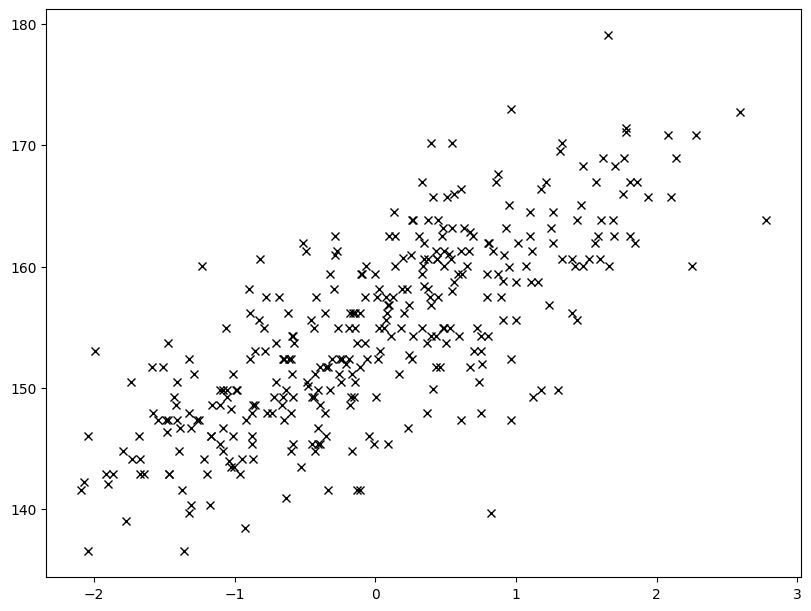

In [157]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.plot(X[:, 0], Y, "kx")
ax.plot(X[:,  0], mean_prediction, "blue", ls="solid", lw=2.0)

In [145]:
mean_prediction

Array([154.69997412, 154.41206737, 154.6433623 , 155.48399565,
       154.69022829, 154.31238257, 154.4226463 , 154.62849463,
       154.16662053, 154.32851842, 154.68114785, 154.82430154,
       155.40711803, 154.99123374, 154.84678042, 154.57985365,
       154.04274605, 154.90079095, 154.51435805, 154.80889152,
       154.79211185, 154.82224465, 154.04371822, 154.69744927,
       155.30944823, 154.24073851, 154.31033857, 155.10968402,
       154.23584959, 154.80494488, 154.48129328, 155.0529332 ,
       154.92744189, 155.12081995, 154.64395329, 154.31210248,
       155.14259049, 155.01717633, 154.84461789, 155.26224062,
       154.50898099, 154.63668542, 154.86859364, 154.34676121,
       154.69317675, 154.41963126, 153.92254502, 154.10695392,
       154.31447678, 154.45199911, 155.13228246, 154.35441004,
       154.70007541, 155.33497049, 154.42470367, 154.61877754,
       154.97420603, 155.01045889, 154.51486206, 154.24760462,
       154.90967492, 154.57661933, 154.47905573, 154.33

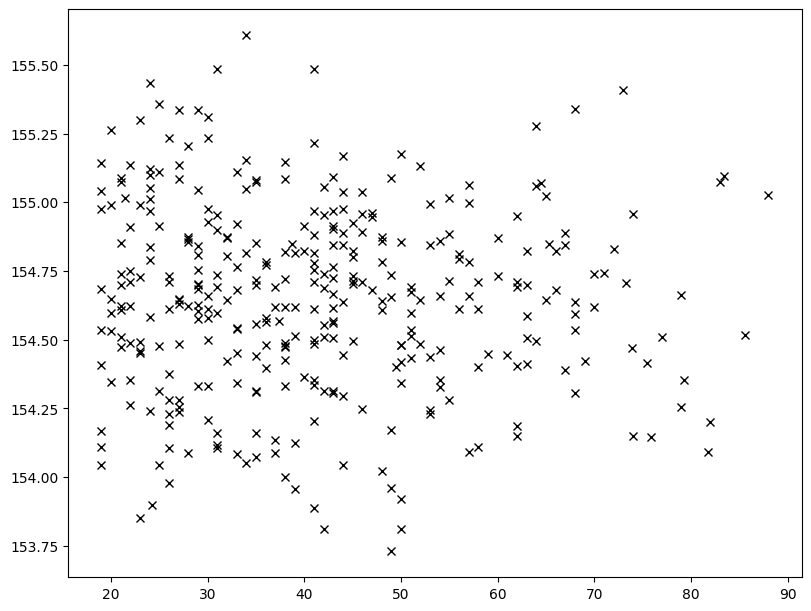

In [130]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.plot(X[:, 1], mean_prediction, "kx")
